In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df= pd.read_csv('data/income_data_2017_clean_zeros.csv.bz2', compression='bz2', index_col='peridnum')

In [3]:
categorical_features = ['PEIOOCC', 'A_HGA', 'PRDTRACE', 'FKIND', 'A_CLSWKR', 'A_WKSTAT',
                       'A_MJIND', 'MJOCC', 'PTYN', 'LJCW', 'A_SEX', 'WEMOCG', 'MIG_CBST',
                       'MIGSAME', 'H_TYPE', 'H_LIVQRT', 'GTCBSA', 'GESTFIPS']
numerical_features = ['H_NUMPER', 'FPERSONS', 'FOWNU6', 'FOWNU18', 'A_AGE', 'A_HRS1',
                     'A_USLHRS', 'PHMEMPRS', 'HRSWK', 'HNUMFAM']
labels = ['ERN_VAL']
features = categorical_features + numerical_features

In [4]:
# converting colum names to uppercase
df.columns = df.columns.str.upper()

In [5]:
df_filt = df[features + labels]
df_filt = df_filt[(df_filt['ERN_VAL'] > 5000) & (df['ERN_VAL'] < 250000)]

In [6]:
categorical_index = [i for i,x in enumerate(df_filt.columns.values) if x in categorical_features]

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [8]:
X = df_filt[features].values
y = (df_filt.ERN_VAL > 40000).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [9]:
steps = [('onehot', OneHotEncoder(categorical_features=categorical_index)),
        ('gradientboost', GradientBoostingClassifier(n_estimators=300,subsample=0.3
                                                     , learning_rate=0.1))]
pipeline = Pipeline(steps)

In [10]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values='auto', sparse=True)), ('gradientboost', GradientBoostingClassifier(criterion='friedman_mse', init=None,
...      presort='auto', random_state=None, subsample=0.3, verbose=0,
              warm_start=False))])

In [11]:
print(pipeline.score(X_test, y_test))

0.808502252252


In [12]:
import sklearn.metrics as met
y_pred = pipeline.predict(X_test)
print(met.confusion_matrix(y_test,y_pred, labels=[0,1]))
print(met.f1_score(y_test,y_pred))

[[10021  1403]
 [ 1998  4338]]
0.718390328724


In [13]:
y_score = pipeline.decision_function(X_test)
fpr, tpr, _ = met.roc_curve(y_test, y_score)

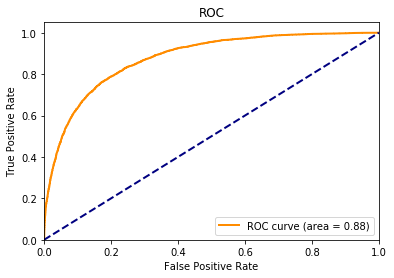

In [14]:
plt.figure()
lw = 2
auc = met.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = {:0.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [15]:
from xgboost import XGBClassifier

In [16]:
steps = [('onehot', OneHotEncoder(categorical_features=categorical_index)),
        ('gradientboost', XGBClassifier(booster='dart'))]
pipeline = Pipeline(steps)

In [17]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('onehot', OneHotEncoder(categorical_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values='auto', sparse=True)), ('gradientboost', XGBClassifier(base_score=0.5, booster='dart', colsample_bylevel=...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [18]:
print(pipeline.score(X_test, y_test))

0.792792792793
